In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image
import matplotlib as mpl
import numpy as np
import geopandas as gpd
import warnings
import time
%matplotlib inline
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.linestyle'] = '--'
mpl.rcParams["figure.figsize"] = [8,8]
mpl.rcParams['lines.markersize'] = 5

Note: this is merely my exploration through the packages and data, they have been consolidated in the other notebook in this same folder

For an introduction to geopanda [darribas.org](https://darribas.org/gds15/)/ [DOI|10.5281/zenodo.46300](http://dx.doi.org/10.5281/zenodo.46313) gives some good insights into the capabilities


### Load in data needed

In [2]:
boarder = gpd.read_file("Contour Data/Boarder-Cambria.shp",crs=4326)
gauges = gpd.read_file("Contour Data/Daily-Gauges-Cumbria.shp",crs=4326)
contours = gpd.read_file("Contour Data/Contours/ny/NY00_line.shp")
spot_heights = gpd.read_file("Contour Data/Contours/ny/NY00_point.shp")
contours.to_crs(epsg=4326,inplace=True)
spot_heights.to_crs(epsg=4326,inplace=True)

#### Explore the data use, filter to post 2018

In [3]:
contours.head()
spot_heights
gauges = gauges.query("last_year >= 2018")
gauges.head(3)

,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry
12,00509,MALHAM TARN,malham-tarn,north-yorkshire,54.100,-2.164,381,1961,2020,POINT (-2.16400 54.10000)
16,25618,BRAMPTON NO 3,brampton-no-3,cumbria,54.935,-2.735,117,2001,2020,POINT (-2.73500 54.93500)
30,01066,DRUMBURGH,drumburgh,cumbria,54.931,-3.158,7,1991,2019,POINT (-3.15800 54.93100)


#### Data can be ploted:

<AxesSubplot:>

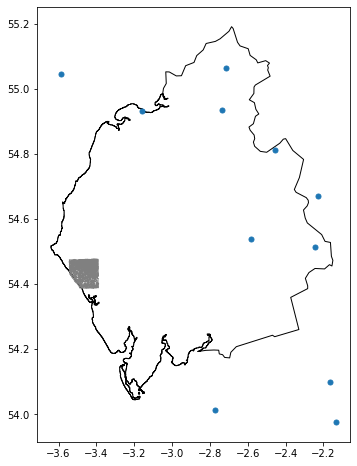

In [4]:
boarder.loc[0, "geometry"]
base = boarder.plot(color="white", edgecolor="black")
gauges.plot(ax=base)
contours.plot(ax=base,color="grey")

#### Contour can also be ploted (takes long)

<Figure size 864x864 with 0 Axes>

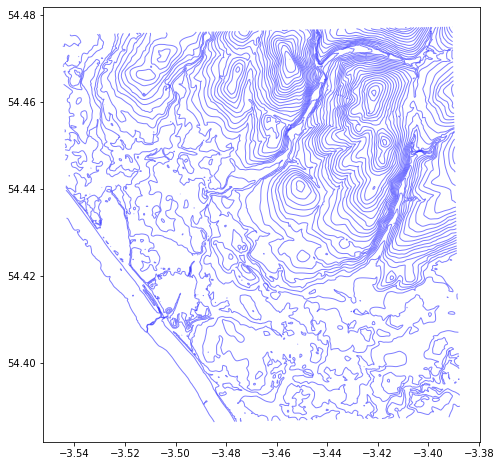

<Figure size 864x864 with 0 Axes>

In [5]:
# spot_heights.plot(ax=base)
contours.plot(color="blue",alpha=0.5)
plt.figure(figsize=(12,12))

#### within the data we can do various calculations , including distance:
post note: take care to use the correct conversion from deg to distance

In [6]:
def distance_between_one_deg(lat):
    """need to find the distance in m one degree, verified here https://www.opendem.info/arc2meters.html"""
    one_arc_second = np.cos(lat * np.pi / 180) * (1852/60)
    return one_arc_second*3600

18.61474500439169 m
28.777305154266962 'roughly' m


,ID,FEAT_TYPE,SUB_TYPE,PROP_VALUE,geometry
20,os.t50.ny00.140,ContourLine,ordinary,200.0,"LINESTRING (-3.39887 54.47604, -3.39889 54.476..."
21,os.t50.ny00.141,ContourLine,ordinary,280.0,"LINESTRING (-3.39046 54.47725, -3.39046 54.47726)"
22,os.t50.ny00.142,ContourLine,ordinary,280.0,"LINESTRING (-3.39046 54.47734, -3.39047 54.477..."


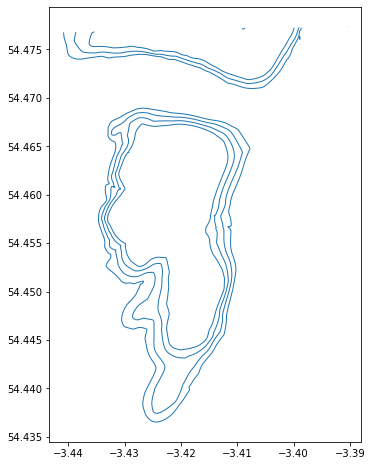

In [7]:
n = 30
sub_section_contours = contours.loc[20:n]
sub_section_contours.plot()
calc_dist = sub_section_contours.iloc[5].geometry.distance(sub_section_contours.iloc[6].geometry) 
print(calc_dist* distance_between_one_deg(54.4),"m")
print(calc_dist*10**5,"'roughly' m")
sub_section_contours.head(3)

#### Be careful as water boundaries are also included: these are not contours

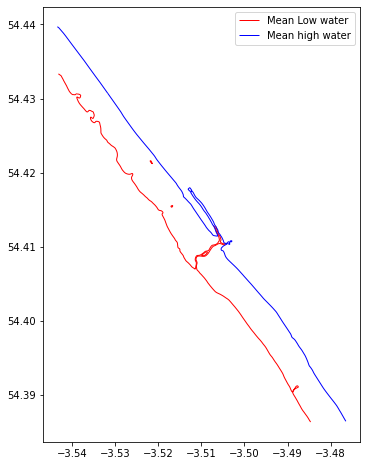

In [8]:
water_boundary = contours.query("FEAT_TYPE!= 'ContourLine'")
low = water_boundary.query("SUB_TYPE =='meanLowWater'").plot(color="red",label="Mean Low water")
water_boundary.query("SUB_TYPE =='meanHighWater'").plot(color="blue",ax=low,label="Mean high water")
plt.legend()

### Code to load different grid part

The data file for contours comes in many files, the code below allows easy accessing of these through storing them in a list. Note this is specific for my file stucture

In [9]:
def bulk_import_shapefiles(file_prefix="ny",n=2,file_type="point"):
    """
    Allows  easy import of shapefiles, use the format as shown in the function.
    Returns two lists: one lst of the geopandas dataframe, other the centres of each grid.
    """
    lst_files = []
    lst_grid = []
    for i in range(n+1):
        # add prefix 0 to single digits
        print(i,end="\r")
        if i < 10:
            index = f"0{i}"
        else:
            index = i
        try:
            # define path name
            filename = f"Contour Data/Contours/{file_prefix}/{file_prefix.upper()}{index}_{file_type}.shp"
            with open(filename):
                pass
            # read file
            shapefile = gpd.read_file(filename)
            shapefile.to_crs(epsg=4326,inplace=True)
            if file_type == "point":
                # indexing code to later find which shapefile we want per gauge: this is with centroids
                warnings.simplefilter("ignore")
                lst_grid.append(shapefile.dissolve().centroid[0])
            ## Inefficient Code
#             if file_type is None:
#                 # indexing code to later find which shapefile we want per gauge: this is with the bounds of the contours
#                 boundaries = shapefile.dissolve().bounds.to_numpy()[0]
#                 lst_grid.append(Point((boundaries[0] + boundaries[2])/2,(boundaries[1] + boundaries[3])/2))
                
            
            # append the df to a list
            lst_files.append(shapefile)
            
        # NY31 doesn't exsist so we do it this way to deal with it
        except FileNotFoundError:
            lst_files.append(None)
            lst_grid.append(None)
            print(f"Missing:{filename}")
            pass
    # finally return it 
    return lst_files,lst_grid

#### This cell runs the the code above for all 99 shapefiles that make up the UK, it can take quite a while...
some areas dont have shapefiles as they are too often small to have points, it merely skips those and inserts a 'none' values(see "except FileNotFoundError" or https://docs.python.org/3/tutorial/errors.html).
<br></br>
_Don't forget to deal with None values or you'll get errors, its mainly done to keep list size consistent_

In [10]:
lst_points, lst_grid_point = bulk_import_shapefiles("ny",99,"point")
lst_lines, empty_list = bulk_import_shapefiles("ny",99,"line")

Missing:Contour Data/Contours/ny/NY31_point.shp
Missing:Contour Data/Contours/ny/NY40_point.shp


#### just some timimg observations (all in seconds)
_This looks at the difference between using centroids of the points of the contours bounding box_<br>
Both:<br>
5.200122594833374 point<br>
103.8294882774353 line<br>

Just point:<br>
5.415998697280884 point<br>
11.819610595703125 line<br>

Just line:<br>
3.759211778640747 point<br>
103.34357380867004 line<br>

Clearly just the point is the best

#### Caculated but then removed as it made code slow :|
Image is still show though:

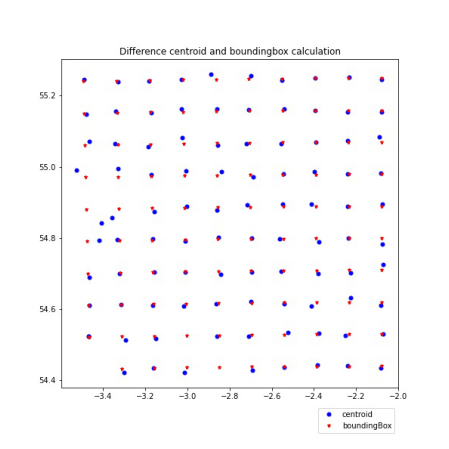

In [11]:
# plt.plot(lst_grid_point[0].x,lst_grid_point[1].y, "bo", alpha=1,label="centroid")
# for i in lst_grid_point[1:]:
#     if i is not None:
#         plt.plot(i.x,i.y, "bo", alpha=1)
# plt.plot(lst_grid_bound_points[0].x,lst_grid_bound_points[1].y, "r*", alpha=1,label="boundingBox")
# for j in lst_grid_bound_points[1:]:
#     if i is not None:
#         plt.plot(j.x,j.y, "r*", alpha=1)
# plt.title("Difference centroid and boundingbox calculation")
# plt.legend(bbox_to_anchor=(1, -0.05))
# # plt.savefig("Plots/Difference centroid and boundingbox cacultation.jpg")


plt.imshow(matplotlib.image.imread("Plots/Difference centroid and boundingbox calculation.jpg"))
plt.axis("off");

### Look at large scale 
again heavy on the computing as inefficient plotting so i've added the figure

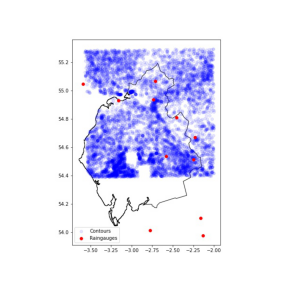

In [12]:
plot = False
if plot:
    base = boarder.plot(color="white", edgecolor="black")
    global_height_diff = []
    for i in lst_points[1:]:
        ## nones are if no data is laoded, simplifies indexing later on
        if i is None:
            pass
        else:
            i.query("FEAT_TYPE == 'ContourLine'")
            i.plot(ax=base,color="blue",alpha=0.1)
    lst_points[0].plot(ax=base,color="blue",alpha=0.1, label="Contours")        
    gauges.plot(ax=base, color='red', label= "Raingauges")
    plt.legend()
# plt.savefig("Plots/Spot heights and rain gauges map of cambria.jpg")


plt.figure(figsize=(5,5))
plt.imshow(matplotlib.image.imread("Plots/Spot heights and rain gauges map of cambria.jpg"))
plt.axis("off");

### looking at just 1 grid cell of 10x10km
More information on the UK national grid: https://digimap.edina.ac.uk/webhelp/os/data_files/os_manuals/os-terrain-50-user-guide_v1.0.pdf

<AxesSubplot:>

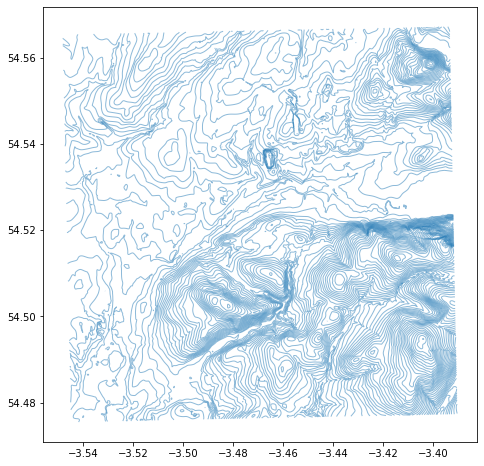

In [13]:
number = 1
fig, ax = plt.subplots()
# lst_points[number].plot(ax=ax,color='blue')
lst_lines[number].plot(ax=ax,alpha=0.5)
# plt.savefig("Plots/One grid cell 10x10km")

### considering just one station
To simplify and cut down on computing: run just one station to experiment with matching gridcells to stations

In [14]:
BRAMPTON_info = gauges.station_la.iloc[2], gauges.station_lo.iloc[2],  gauges.station_el.iloc[2]
BRAMPTON = gauges.query("src_id == '25618'")
BRAMPTON

,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry
16,25618,BRAMPTON NO 3,brampton-no-3,cumbria,54.935,-2.735,117,2001,2020,POINT (-2.73500 54.93500)


#### using just one station, look up grid cell:
https://gridreferencefinder.com/#gr=NY7500575686|55.075_s__c__s_-2.393|1 <br>
which yiels 75,75: so take that index, ~but seems to be a fluke~: was due to the way we load data and handel skips, now includes a None type which is then handeled lateron

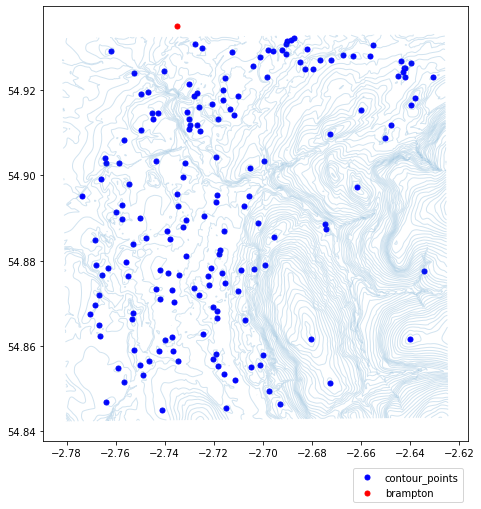

In [15]:
base = lst_points[55].plot(label= "contour_points",color="blue")
BRAMPTON.plot(ax=base,label="brampton",color="red")
lst_lines[55].plot(ax=base,alpha =0.2)
plt.legend(bbox_to_anchor=(1, -0.05))

### Rather than transforming to gridreferences, try find mean value for a gridref

In [16]:
lst_lines[2].dissolve().centroid

0    POINT (-3.46839 54.60863)
dtype: geometry

 After this I went back to change the import function prev written, now we can access that list, thus the code below is redundant

In [17]:
# lst_distances = []
# for i in lst_grid_point:
#     if i is None:
#         lst_distances.append(np.inf)
#     else:
#         lst_distances.append(i.distance(WARK.iloc[0].geometry))
# closest = min(lst_distances)
# lst_distances.index(closest)

Wrote out my previosu steps to do it for the gauge whole data set:

In [18]:
def select_closest_grid(gauge):
    """
    Takes the grid refference closest to the gauge and returns that index.
    """
    lst_distances = []
    for i in lst_grid_point:
        if i is None:
            lst_distances.append(np.inf)
        else:
            lst_distances.append(i.distance(gauge))
    closest = min(lst_distances)
    return lst_distances.index(closest)

def select_closest_dist(gauge):
    """
    Takes the grid refference closest to the gauge and returns the distance.
    """
    lst_distances = []
    for i in lst_grid_point:
        if i is None:
            lst_distances.append(np.inf)
        else:
            lst_distances.append(i.distance(gauge))
    closest = min(lst_distances) * distance_between_one_deg(54.4)
    return closest

def select_closest_diff(gauge):
    """
    Takes the grid refference closest to the gauge and returns the distance.
    """
    lst_distances = []
    for i in lst_grid_point:
        if i is None:
            lst_distances.append(np.inf)
        else:
            lst_distances.append(i.distance(gauge))
    closest1 = min(lst_distances) * distance_between_one_deg(54.4)
    for i in lst_grid_point:
        if i is None:
            lst_distances.append(np.inf)
        else:
            lst_distances.append(i.distance(gauge))
    closest2 = min(lst_distances)* distance_between_one_deg(54.4)
    return closest

#### Apply these to the data set and run it

In [19]:
gauges["grid_id"] = gauges.geometry.apply(select_closest_grid)
gauges["grid_id_distance"] = gauges.geometry.apply(select_closest_dist)

In [20]:
gauges.head(3)

,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry,grid_id,grid_id_distance
12,00509,MALHAM TARN,malham-tarn,north-yorkshire,54.100,-2.164,381,1961,2020,POINT (-2.16400 54.10000),90,22235.005172
16,25618,BRAMPTON NO 3,brampton-no-3,cumbria,54.935,-2.735,117,2001,2020,POINT (-2.73500 54.93500),55,2911.538665
30,01066,DRUMBURGH,drumburgh,cumbria,54.931,-3.158,7,1991,2019,POINT (-3.15800 54.93100),26,3243.501616


Then write a function to plot neatly given the index of a station, the surrounding and location of gridcell

In [21]:
def plot_station(index=0, annotate=False):
    station = gauges.iloc[index]
    base = lst_points[station.grid_id].plot(label= "contour_points",color="blue")
    plt.plot(station.station_lo,station.station_la,"ro",label=f"{station.station_na} weather station")
    lst_lines[station.grid_id].plot(ax=base,alpha =0.1)
    plt.title(f"Distance to gridcell center:{station.grid_id_distance/1000:.3f}km ")
    plt.legend(bbox_to_anchor=(1, -0.05))
    if annotate:
        height = lst_points[station.grid_id].PROP_VALUE.to_numpy()
        x = lst_points[station.grid_id].geometry.x.to_numpy()
        y = lst_points[station.grid_id].geometry.y.to_numpy()
        for i, txt in enumerate(height):
            base.annotate(txt,(x[i],y[i]),label="Height above mean sea-level")

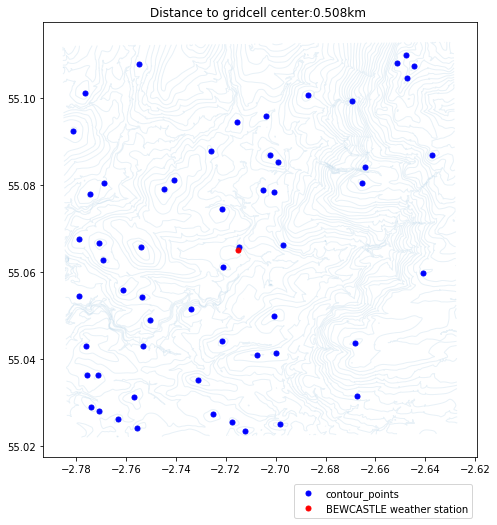

In [22]:
plot_station(7)

#### To veryify it works, we see this:

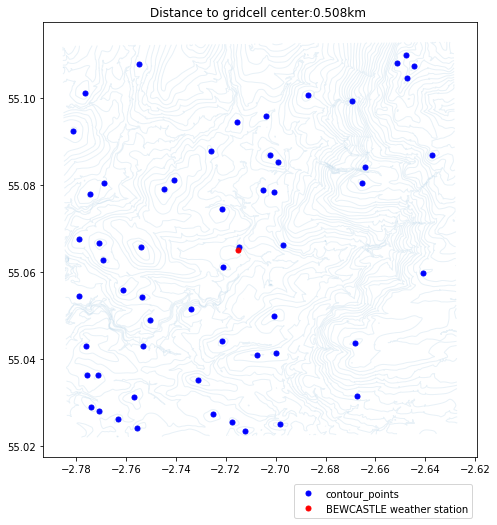

In [23]:
for i in range(7,8):
    plot_station(i)

#### But not always:

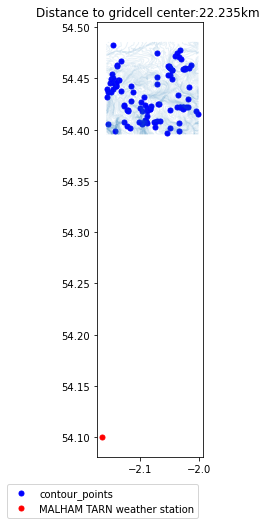

In [24]:
plot_station(0);

#### So filter out those that aren't in

In [25]:
gauges_in_cell = gauges.query("grid_id_distance < 5000")

#### Give an overview of the cells that fit in:

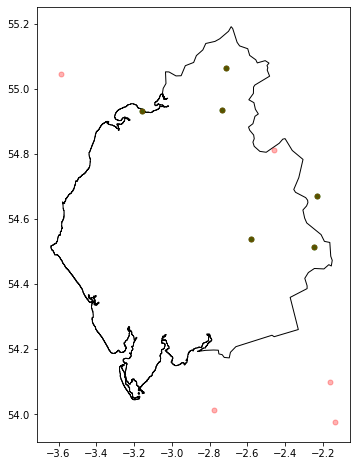

In [26]:
base = boarder.plot(color="white", edgecolor="black")
gauges_in_cell.plot(ax=base, color="green", label="Stations within a gridcell")
gauges.plot(ax=base, color='red',alpha=0.3, label="All stations");

#### We see its mostly those on the edges, but not all, if we change the threshold to 10km:
In the end I went for 5000m instead as this gave beter resulst but is good to keep in mind

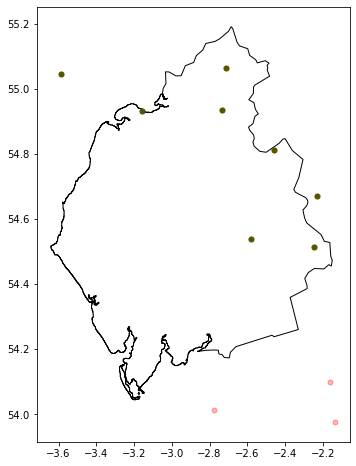

In [27]:
gauges_in_cell = gauges.query("grid_id_distance < 10000")
base = boarder.plot(color="white", edgecolor="black")
gauges_in_cell.plot(ax=base, color="green", label="Stations within a gridcell")
gauges.plot(ax=base, color='red',alpha=0.3, label="All stations");

The finaly query used:
    

In [28]:
# gauges_in_cell = gauges.query("grid_id_distance < 5000")

Reseting the index as we dropped many cells:

In [29]:
gauges_in_cell.reset_index(inplace=True)
gauges_in_cell.reset_index(inplace=True)

In [30]:
gauges_in_cell.drop(columns="index",inplace=True)
gauges_in_cell.head(3)

,level_0,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry,grid_id,grid_id_distance
0,0,25618,BRAMPTON NO 3,brampton-no-3,cumbria,54.935,-2.735,117,2001,2020,POINT (-2.73500 54.93500),55,2911.538665
1,1,01066,DRUMBURGH,drumburgh,cumbria,54.931,-3.158,7,1991,2019,POINT (-3.15800 54.93100),26,3243.501616
2,2,24793,"ALSTON, SPRINGHOUSE PARK",alston-springhouse-park,cumbria,54.811,-2.457,320,1998,2019,POINT (-2.45700 54.81100),74,5331.731139


To create a general map idea we can interpolate, atleast that was the plan, but lets not


In [31]:
# from scipy.interpolate import griddata

#### Tried to use Scipy, not really what we want 

Wrong approach, nice idea

In [32]:
# df_wark["x"] = df_wark["geometry"].x
# df_wark["y"] = df_wark["geometry"].y
# # df_wark

In [33]:
# zi = griddata((df_wark.x,df_wark.y), df_wark.PROP_VALUE, gauges_in_cell.iloc[0].geometry)

In [34]:
# zi # given 219 not bad.. pretty significant error

In [35]:
# xmax, ymax, xmin, ymin = df_wark.geometry.total_bounds
# print(xmax, ymax, xmin, ymin)
# grid = 10
# x = np.linspace(xmax,xmin,grid)
# y = np.linspace(ymax,ymin,grid)
# x,y
# z2 = griddata((df_wark.x,df_wark.y), df_wark.PROP_VALUE, (x,y))
# z = np.dstack([x,y])
# z
# xi, yi = np.meshgrid(x, y)
# station = gauges.iloc[2]
# base = lst_points[station.grid_id].plot(label= "contour_points",color="blue")
# sns.kdeplot(df_wark['x'], df_wark['y'],ax = base,weights=df_wark["PROP_VALUE"], n_levels=200, cmap='BuPu',alpha=0.5)
# plt.plot(station.station_lo,station.station_la,"ro",label=f"{station.station_na} weather station")
# lst_lines[station.grid_id].plot(ax=base)
# plt.title(f"Distance to gridcell center:{station.grid_id_distance/1000:.3f}km ")
# plt.xlim((-2.5,-2.3))
# plt.ylim((55.02,55.12))
# plt.legend();

#### Need to look into extracting the gradient from shapefiles

In order to look at the slopes, we need to use a combination of spotheights and contour lines.
To first try is to look at at the closest contour line in the area. 

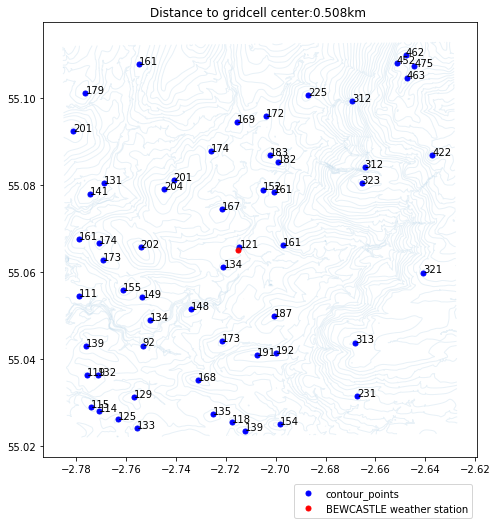

In [36]:
plot_station(7,annotate=True)
# plot_station(7)
# plt.xlim((-2.75,-2.68))
# plt.ylim((55.04,55.08));
# plt.savefig("Plots/Map showing raingauge linked to gridcell")

Some helper code to get the df

In [37]:
def get_df_per_station(index=0):
    """
    Insert index of the gauges df and returns spotheights and contour dfs
    """
    station = gauges_in_cell.iloc[index]
    spot_heights = lst_points[station.grid_id]
    contour_lines = lst_lines[station.grid_id]
    return spot_heights, contour_lines

#### Need some way of analysing the gradients: we know that every gridline = 50m, first look at clost gridlines

In [38]:
gauges.iloc[7]

src_id                              61875
station_na                      BEWCASTLE
station_fi                      bewcastle
historic_c                        cumbria
station_la                         55.065
station_lo                         -2.715
station_el                            133
first_year                           2013
last_year                            2020
geometry            POINT (-2.715 55.065)
grid_id                                57
grid_id_distance               507.920828
Name: 61, dtype: object

In [39]:
spot_heights, contourlines = get_df_per_station(7)

In [40]:
gauges_in_cell.reset_index(inplace=True)

Takes the code above and puts it in a function to select the closest contours
the geometry.distance is used to find the distance between the objects


In [41]:
def select_closest_contour(gauge_id):
    """
    Takes gauge_id and returns df sorted by proximity of their centroids
    """
    ### station needs to be defined
    station = gauges_in_cell.iloc[gauge_id]
    def distance_to_gauge(df):
        """Calculates distance to given station and adds to df column"""
        return df.distance(station.geometry)
    
    spot_heights, contourlines = get_df_per_station(gauge_id)
    contourlines['distance_to_gauge'] = contourlines.geometry.apply(distance_to_gauge)* distance_between_one_deg(54.4)
    return contourlines.sort_values('distance_to_gauge')


As we have an idea of what the closest contours are, we can then plot them

In [42]:
def plot_closest_contours(index=0, annotate=False, spot_heights=False, distances=False, selected_n=10):
    station = gauges_in_cell.iloc[index]
    base = select_closest_contour(index).head(selected_n).plot(alpha =0.5)
    plt.plot(station.station_lo,station.station_la,"ro",label=f"{station.station_na} weather station")
    
    if distances:
        line = select_closest_contour(index).head(selected_n).iloc[0].geometry
        point = gauges_in_cell.iloc[index].geometry
        distance_contour=point.distance(line.interpolate(line.project(point)))* distance_between_one_deg(54.4)
        plt.title(f"Distance to closest contour: {distance_contour:.3f}m ")
        
    if spot_heights:
        lst_points[station.grid_id].plot(ax=base, label= "contour_points",color="blue")
        
    if annotate:
        height = lst_points[station.grid_id].PROP_VALUE.to_numpy()
        x = lst_points[station.grid_id].geometry.x.to_numpy()
        y = lst_points[station.grid_id].geometry.y.to_numpy()
        for i, txt in enumerate(height):
            base.annotate(txt,(x[i],y[i]))
        height = lst_lines[station.grid_id].PROP_VALUE.to_numpy()
        
    if selected_n < 31:
        select_closest_contour(index).head(selected_n).centroid.plot(ax=base,label="centroid",color="green")
        
    plt.legend(bbox_to_anchor=(1, -0.1));
#     return base

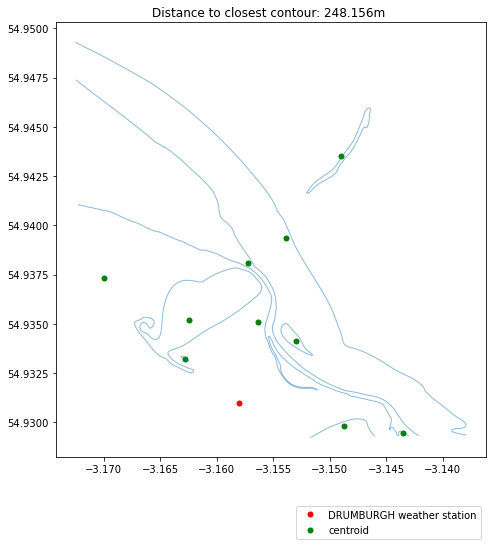

In [43]:
plot_closest_contours(1, False, False, True, 10);

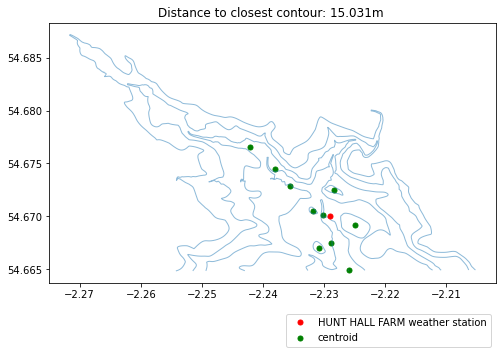

In [44]:
plot_closest_contours(5, False, False, True, 10);

In [57]:
def distance_to_n_contours(index=0,selected_n=10):
    """
    Repeats select_closest_contour() but for index of df, returns new df
    """
    contours = select_closest_contour(index).head(selected_n)
    point = gauges_in_cell.iloc[index].geometry
    distance_contour = []
    for i in range(selected_n):
        line = contours.iloc[i].geometry
        distance_contour.append(point.distance(line.interpolate(line.project(point)))*distance_between_one_deg(54.4))
    return contours

In [46]:
# for i in range(1):
#     print(i,distance_to_n_contours(i,4))

In [47]:
distance_to_n_contours(5,4)

,ID,FEAT_TYPE,SUB_TYPE,PROP_VALUE,geometry,distance_to_gauge
226,os.t50.ny83.256,ContourLine,ordinary,370.0,"LINESTRING (-2.22333 54.66488, -2.22343 54.664...",15.030690
223,os.t50.ny83.253,ContourLine,ordinary,380.0,"LINESTRING (-2.24298 54.66484, -2.24356 54.664...",105.226618
233,os.t50.ny83.263,ContourLine,ordinary,380.0,"LINESTRING (-2.22383 54.66794, -2.22396 54.667...",110.872319
227,os.t50.ny83.257,ContourLine,ordinary,380.0,"LINESTRING (-2.23152 54.67023, -2.23166 54.670...",136.698183


Technique is called linear referencing from [stackoverflow](https://stackoverflow.com/questions/24415806/coordinates-of-the-closest-points-of-two-geometries-in-shapely) and [shapely](https://shapely.readthedocs.io/en/latest/manual.html#linear-referencing-methods)

In [48]:
def closest_point_on_contour(index=0,selected_n=10):
        contours = select_closest_contour(index).head(selected_n)
        rain_gauge = gauges_in_cell.iloc[index].geometry
        
        def point_on_contour(line):
            """finds point on contour used to project and  adds to df column"""
            return line.interpolate(line.project(rain_gauge))
    
        contours["point_on_contour"] = contours.geometry.apply(point_on_contour)
        
        return contours

<AxesSubplot:>

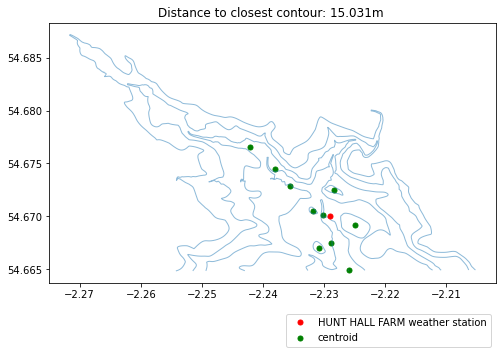

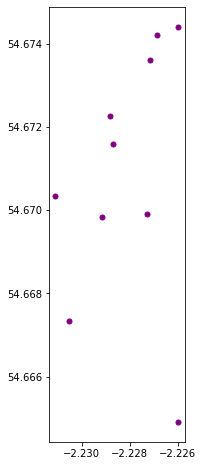

In [49]:
base = plot_closest_contours(5, False, False, True, 10);
closest_point_on_contour(5).point_on_contour.plot(ax=base,label="Closest points on contours",color="Purple")

#### repeat code but if i understand == fine? (just adding purple points at end)

In [50]:
def plot_closest_point_contours(index=0, annotate=False, spot_heights=False, distances=False, selected_n=10):
    station = gauges_in_cell.iloc[index]
    base = select_closest_contour(index).head(selected_n).plot(alpha =0.5)
    plt.plot(station.station_lo,station.station_la,"ro",label=f"{station.station_fi} weather station")
    if distances:
        line = select_closest_contour(index).head(selected_n).iloc[0].geometry
        point = gauges_in_cell.iloc[index].geometry
        distance_contour=point.distance(line.interpolate(line.project(point)))* distance_between_one_deg(54.4)
        plt.title(f"Distance to closest contour: {distance_contour:.3f}m ")
    if spot_heights:
        lst_points[station.grid_id].plot(ax=base, label= "contour_points",color="blue")
    if annotate:
        height = lst_points[station.grid_id].PROP_VALUE.to_numpy()
        x = lst_points[station.grid_id].geometry.x.to_numpy()
        y = lst_points[station.grid_id].geometry.y.to_numpy()
        for i, txt in enumerate(height):
            base.annotate(txt,(x[i],y[i]))
        height = lst_lines[station.grid_id].PROP_VALUE.to_numpy()
    if selected_n < 31:
        select_closest_contour(index).head(selected_n).centroid.plot(ax=base,label="Centroid of lines",color="green")
        closest_point_on_contour(index).point_on_contour.plot(ax=base,label="Closest points on contours",color="purple")
    plt.legend(bbox_to_anchor=(1, -0.03))
    return base

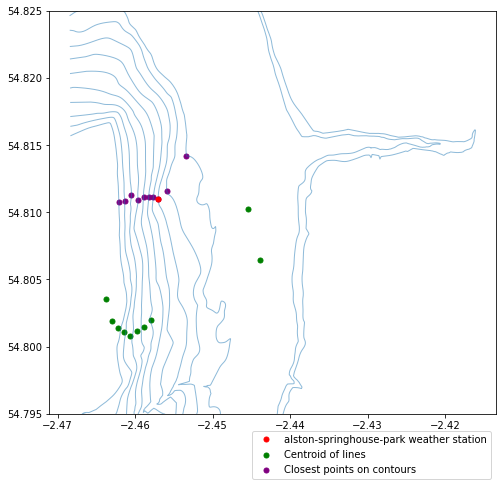

In [51]:
for i in range(2,3):
    plot_closest_point_contours(i)
    plt.ylim((54.795,54.825))
#     plt.savefig("Plots/Selected 10 closest contours.png")

#### This is already sorted by distance to gauge: 

In [52]:
def sorted_distance_between_points_on_contours(index=0, selected_n=10):
    contour = closest_point_on_contour(index,selected_n)
    points = contour.point_on_contour.to_numpy()
    distance = []
    for i in range(len(points)):
        if i == len(points) - 1:
            pass
        else:
#             print(points[i].x,points[i].y)
            distance.append(round(points[i].distance(points[i+1])* distance_between_one_deg(54.4)))
    return sum(distance) / len(distance)

### This resorts it to take closest

In [53]:
def resorted_points_on_contours(index=0, selected_n=10):
    contour = closest_point_on_contour(index,selected_n)
    points = list(contour.point_on_contour.to_numpy())
    
    # start with the furthest Node
    current_node = contour.point_on_contour.iloc[selected_n-1]
    
    # add this to the list of current nodes
    index_chosen_points = [selected_n-1]
    chosen_points = [current_node]
    chosen_distances = []
    
    # and remove the node from out list, replacing it with none to preserve indexing
    points[selected_n-1] = None
    
    #run untill 1 ellement left 
    while len(index_chosen_points) < len(points):
        
        # create a new list to store distances
        lst_distance = []
        
        # loop over all points
        for i in points:
            # check its not already chosen
            if i is not None:
                # caculate distance from current to all others
                lst_distance.append(round(current_node.distance(i)* distance_between_one_deg(54.4)))
            else:
                # again preserving indexes
                lst_distance.append(np.inf)
        
        # take the minimum of the caculated nodes and find the index
        closest = min(lst_distance)
        # print(lst_distance)
        new_index = lst_distance.index(closest)
        
        # reassign new node and remove the current_node from the points list
        current_node = contour.point_on_contour.iloc[selected_n-1]
        points[new_index] = None
        
        # add this index to the selected list
        index_chosen_points.append(new_index)
        chosen_points.append(current_node)
        chosen_distances.append(round(closest))

    return sum(chosen_distances)/len(chosen_distances)

In [54]:
distances = resorted_points_on_contours(0)
distances

663.1111111111111

In [55]:
def sorted_slope_angle(index):
    return round(50 * 100 /sorted_distance_between_points_on_contours(index),2)

def resorted_slope_angle(index):
    return round(50 * 100 /resorted_points_on_contours(index),2)

In [56]:
gauges_in_cell["Slope_%_sorted"] = gauges_in_cell.level_0.apply(sorted_slope_angle)
gauges_in_cell["Slope_%_resorted"] = gauges_in_cell.level_0.apply(resorted_slope_angle)
gauges_in_cell.drop(columns=["level_0","station_na","historic_c"])

,index,src_id,station_fi,station_la,station_lo,station_el,first_year,last_year,geometry,grid_id,grid_id_distance,Slope_%_sorted,Slope_%_resorted
0,0,25618,brampton-no-3,54.935,-2.735,117,2001,2020,POINT (-2.73500 54.93500),55,2911.538665,8.38,7.54
1,1,01066,drumburgh,54.931,-3.158,7,1991,2019,POINT (-3.15800 54.93100),26,3243.501616,7.33,5.23
2,2,24793,alston-springhouse-park,54.811,-2.457,320,1998,2019,POINT (-2.45700 54.81100),74,5331.731139,26.58,18.69
3,3,19259,dumfries-crichton-royal-no-2,55.047,-3.589,50,1997,2020,POINT (-3.58900 55.04700),6,5430.516598,9.17,5.10
4,4,61875,bewcastle,55.065,-2.715,133,2013,2020,POINT (-2.71500 55.06500),57,507.920828,21.62,11.44
5,5,17183,hunt-hall-farm,54.670,-2.229,370,1995,2020,POINT (-2.22900 54.67000),83,2038.816499,20.35,10.50
6,6,62037,maulds-meaburn,54.538,-2.582,183,2015,2020,POINT (-2.58200 54.53800),61,3764.287196,14.36,8.43
7,7,62082,south-stainmore-no-2,54.513,-2.245,291,2016,2018,POINT (-2.24500 54.51300),81,1013.069407,19.83,15.42


#### See next notebook for itterable and concicer code